# Road Accident Traffic Prediction
Eamon Gallagher, Eric Greenstein, Shubham Kumar
<br><br>

Even minor accidents can have an effect on traffic patterns. The goal of this project is to predict how long an accident will affect traffic based on the information available when it occurs.

Knowing when an accident will clear is integral to many kinds of services. Web mapping services like Apple’s “Maps,” for example, rely on this information for quality routing.
<br><br>

Data Set: “US Accidents (Updated)” 

From kaggle.com:
https://www.kaggle.com/sobhanmoosavi/us-accidents

Includes data from 1.5 million US motor vehicle accidents from 2016-2020. data was collected from traffic APIs that compile a variety of information from a multitude of sources. 

The questions this project seeks to answer are :
1. What factors affect an accident time to clear?
2. Can we effectively predict how long in minutes an accident will affect traffic flow?
<br>

Every step of this project was completed using the pyspark module for apache spark. More information about spark can be found [here.](https://spark.apache.org/) 







## Loading necessary software, modules and functions into Google Colab:

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
import findspark

findspark.init()
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.config("spark.executor.memory","16g").getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql
from pyspark.sql.functions import expr, upper

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# connecting to gdrive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Loading the Data

In [ ]:
# loading accidents as a spark dataframe
# the path will need to be updated to wherever the data file is stored within your gdrive or system.
accidents = spark.read.csv(path = 'gdrive/My Drive/Big Data Final Project/US_Accidents_Dec20_updated.csv', inferSchema=True, sep=',', header=True)

# long format can be used to calculate the distance between times
# length seconds represents the distance between the start and end times
# timestamps can be used to retrieve hour of day, day of week, etc
accidents = accidents.withColumn("Start_Timestamp", fn.col("Start_Time").cast("timestamp").cast("long"))
accidents = accidents.withColumn("End_Timestamp", fn.col("End_Time").cast("timestamp").cast("long"))
accidents = accidents.withColumn("Length_Seconds",fn.col("End_Timestamp") - fn.col("Start_Timestamp"))
accidents = accidents.withColumn("Start_Real_Timestamp",fn.col("Start_Time").cast("timestamp"))
accidents = accidents.withColumn("End_Real_Timestamp",fn.col("End_Time").cast("timestamp"))

# selecting columns needed from analysis
# seconds in minutes and seconds and ours also added
accidents2 = accidents.select(fn.col('Severity').cast('int'), 
                              (fn.col('Side') == "R").alias('Right_Side').cast('int'), 
                              fn.col('Start_Timestamp'), 
                              fn.col('End_Timestamp'), 
                              fn.col("Length_Seconds"), 
                              fn.col('Start_Real_Timestamp'),
                              fn.col('End_Real_Timestamp'),
                              (fn.round(fn.col("Length_Seconds")/60)).cast('int').alias("Length_Minutes"), 
                              (fn.round(fn.col("Length_Seconds")/3600)).cast('int').alias("Length_Hours"),
                              fn.col('Distance(mi)').alias('Distance_mi'), 
                              (fn.col('Number').isNotNull()).alias('Has_Number').cast('int'), 
                              fn.col('Timezone'), 
                              fn.col('Temperature(F)').cast("int"), 
                              fn.col('Wind_Chill(F)').cast("int"), 
                              fn.col('Humidity(%)').cast("int"), 
                              fn.col('Pressure(in)').cast("int"), 
                              fn.col('Weather_Condition'),
                              (fn.col('Sunrise_Sunset') == 'Day').alias('Is_Day').cast('int'), 
                              fn.col('Description'),
                              fn.col('Amenity').cast('int'),
                              fn.col('Bump').cast('int'),
                              fn.col('Crossing').cast('int'),
                              fn.col('Give_Way').cast('int'),
                              fn.col('Junction').cast('int'),
                              fn.col('No_Exit').cast('int'),
                              fn.col('Railway').cast('int'),
                              fn.col('Roundabout').cast('int'), 
                              fn.col('Station').cast('int'), 
                              fn.col('Stop').cast('int'), 
                              fn.col('Traffic_Calming').cast('int'), 
                              fn.col('Traffic_Signal').cast('int'),
                              fn.col('Turning_Loop').cast('int'),
                              upper(fn.col('Wind_Direction')),
                              fn.col('Visibility(mi)').cast("int"),
                              fn.col('Wind_Speed(mph)').cast("int"),
                              fn.col('Precipitation(in)').cast("int"),
                              fn.col('Start_Lat'),
                              fn.col('Start_Lng'))

accidents2.cache()
accidents2.count()

1516064

In [ ]:
accidents2.show(5)

+--------+----------+---------------+-------------+--------------+--------------------+-------------------+--------------+------------+-----------+----------+----------+--------------+-------------+-----------+------------+-----------------+------+--------------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+---------------------+--------------+---------------+-----------------+---------+---------+
|Severity|Right_Side|Start_Timestamp|End_Timestamp|Length_Seconds|Start_Real_Timestamp| End_Real_Timestamp|Length_Minutes|Length_Hours|Distance_mi|Has_Number|  Timezone|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Weather_Condition|Is_Day|         Description|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|upper(Wind_Direction)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Start_Lat|Start_Lng|
+--------+----------+---------

# Data Cleaning

The data was collected from several different sources, meaning there were NA values, duplicates, and other anomalies that need to be addressed before further analysis can be done

### NAS, Duplicates and "Six_Hour" Observations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6509923810>]],
      dtype=object)

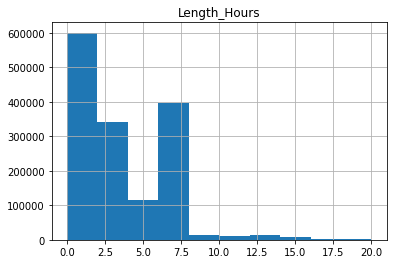

In [ ]:
# This plot represents a large spike in number of accidents that lasted about 6 hours
accidents2.select(fn.col('Length_Hours')).where(fn.col('Length_Hours') <= 20).toPandas().hist(column = "Length_Hours")

In [ ]:
# looking closer we realized many accidents lasted exactly 6 hours.
# this is likely a default value for accidents not properly recorded
# adding a column for observations with exactly 6 hours for length
accidents2 = accidents2.withColumn("Six_Hours", (fn.col('Length_Seconds') == 21600))

In [ ]:
# most columns don't show a significant difference for numerical columns when length is exactly 6 hours
# wind chill is much lower, meaning it was probably recorded differently or had a default value of 0
# an average windchill 30 degrees lower than average temperature is more than just unlikely
accidents2.groupby('Six_Hours').agg(fn.count('Has_Number').alias('Count'), fn.avg('Distance_mi'), fn.avg('Temperature(F)'), fn.avg('Wind_Chill(F)'), 
                                    fn.avg('Humidity(%)'), fn.avg('Pressure(in)')).show()

+---------+-------+------------------+-------------------+------------------+------------------+------------------+
|Six_Hours|  Count|  avg(Distance_mi)|avg(Temperature(F))|avg(Wind_Chill(F))|  avg(Humidity(%))| avg(Pressure(in))|
+---------+-------+------------------+-------------------+------------------+------------------+------------------+
|     true| 367648|0.6993420445643391|  62.71783771443844| 27.54027156814042|63.455947357566096|29.534066336713366|
|    false|1148416|0.5513809011717078|  58.45236421487166| 56.72459204378561| 65.04805726431225|28.898813527377836|
+---------+-------+------------------+-------------------+------------------+------------------+------------------+



In [ ]:
# after dropping nas, we can see about 85% of the Six_Hours observations had NAs in relevant columns
# this is compared to only about 10% for the rest of the observations
# temperature is much lower for this subset of 6 hour observations.
# altogether we can conclude that these observations probably came from a different source
accidents2 = accidents2.na.drop()
accidents2.groupby('Six_Hours').agg( fn.count('Has_Number').alias('Count'), fn.avg('Distance_mi'), fn.avg('Temperature(F)'), fn.avg('Wind_Chill(F)'), fn.avg('Humidity(%)'), fn.avg('Pressure(in)')).show()

+---------+------+------------------+-------------------+------------------+-----------------+------------------+
|Six_Hours| Count|  avg(Distance_mi)|avg(Temperature(F))|avg(Wind_Chill(F))| avg(Humidity(%))| avg(Pressure(in))|
+---------+------+------------------+-------------------+------------------+-----------------+------------------+
|     true| 15278|1.0542181568268074|  39.61886372561854|32.896845136798014| 79.8393114281974|  29.2154732294803|
|    false|926601|0.5322343112083914| 58.888931697677855| 57.64104398764948|65.09654209309078|28.812603267209944|
+---------+------+------------------+-------------------+------------------+-----------------+------------------+



In [ ]:
# for good measure, lets look at the distinct observations left
# out of the remaining observations, the Six_Hour observations had a much smaller percentage of duplicates
accidents2 = accidents2.distinct()
accidents2.groupby('Six_Hours').agg(fn.count('Has_Number').alias('Count'), fn.avg('Distance_mi'), fn.avg('Temperature(F)'), fn.avg('Wind_Chill(F)'), fn.avg('Humidity(%)'), fn.avg('Pressure(in)')).show()

+---------+------+------------------+-------------------+------------------+-----------------+------------------+
|Six_Hours| Count|  avg(Distance_mi)|avg(Temperature(F))|avg(Wind_Chill(F))| avg(Humidity(%))| avg(Pressure(in))|
+---------+------+------------------+-------------------+------------------+-----------------+------------------+
|     true| 15182|1.0603868396785667|  39.58009484916348|32.846923988934265|79.85081016993809|29.215518377025425|
|    false|816572|0.5112853232782903|  59.31383025624195|  58.0811869620805|64.67303311894113|28.787361065527595|
+---------+------+------------------+-------------------+------------------+-----------------+------------------+



In [ ]:
# after duplicates, observations with NAs in relevant columns and Six_Hour observations,
# we are left with 816,572 observations
accidents3 = accidents2.where(fn.col('Six_Hours') == False)
accidents2.unpersist()
accidents3.cache()
accidents3.count()

816572

### Removing Outliers

Outliers can skew a model, making it less effective at prediction of standard observations. Given the continuous nature of the problem and our regression based solutions, we have decided to remove outliers to best predict the result of more common cases.

### Outliers in length of traffic
There were some extreme outliers (thousands of hours) which absolutely wrecked the predictive capability of the models.

In [ ]:
# outliers were determined using Q1 - IQR and Q3 + IQR
# almost all accidents lasted under 5 hours
quartiles = accidents3.agg(fn.expr("percentile(Length_Minutes, array(.25, .5, .75))"))
firstQuartile = quartiles.first()[0][0]
median = quartiles.first()[0][1]
thirdQuartile = quartiles.first()[0][2]

iqr = thirdQuartile - firstQuartile
Q3_plus_iqr = thirdQuartile + iqr 

print('Outliers for Length of accident are greater than', Q3_plus_iqr, 'minutes, or', Q3_plus_iqr/60, 'hours')

Outliers for Length of accident are greater than 282.0 minutes, or 4.7 hours


In [ ]:
# 752,281 observations recorded accidents with length under 5 hours
# these are the observations we will use to build our model
accidents3 = accidents3.where(fn.col('Length_Hours')<=5)
accidents3.count()

752281

### Additional Outliers: Pressure(in) and Distance(mi)


We decided IQR is a good representation of outliers in other columns

In [ ]:
accidents3 = accidents3.where(fn.col('Pressure(in)')<=29)
accidents3 = accidents3.where(fn.col('Distance_mi')<=2.5)
accidents3.count()

584760

# Feature Engineering

## Time

### Adding Hour Bins

In [ ]:
# This Function allows us to pull the hours from the timesatmps present in the data
from pyspark.sql.functions import hour

In [ ]:
# Adding a column for hour of the day (Numerical)
accidents3 = accidents3.withColumn('Hour_Of_The_Day',hour(accidents2.Start_Real_Timestamp))

In [ ]:
# This function allows us to easily create categorical groups for numerical variables.
from pyspark.ml.feature import Bucketizer

In [ ]:
# The first function selects the splits for the groupings, every group is split by "Lower Range" <= Xi < "Upper Range" 
bucketizer = Bucketizer(splits=[ 0, 2, 4, 6,8,10,12,14,16,18,20,22, float('Inf') ],inputCol="Hour_Of_The_Day", outputCol="Hour_Buckets")
# This creates a new column in our data set that has each of the buckets for time
accidents3 = bucketizer.setHandleInvalid("keep").transform(accidents3)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [ ]:
# This first line creates a dictionary for the buckets
# The second line creates a udf to itterate through the data easily
# The third line adds the categorical buckets column to the data set
Buckets = {0.0:"12am to 2am", 1.0: "2am to 4am", 2.0:"4am to 6am", 3.0: "6am to 8am", 4.0: "8am to 10am", 5.0: "10am to 12pm", 6.0: "12pm to 2pm", 7.0: "2pm to 4pm", 8.0: "4pm to 6pm", 9.0: "6pm to 8pm", 10.0: "8pm to 10pm", 11.0: "10pm to 12am"}
udf = udf(lambda x: Buckets[x], StringType())
accidents3 = accidents3.withColumn("Hour_Buckets_Named", udf("Hour_Buckets"))

In [ ]:
# Checking results of buckting
# These categorical values will be indexed during the model building process
accidents3.select(fn.col("Hour_Buckets_Named"),fn.col("Hour_Of_The_Day")).show(10)

+------------------+---------------+
|Hour_Buckets_Named|Hour_Of_The_Day|
+------------------+---------------+
|        2pm to 4pm|             15|
|       12am to 2am|              1|
|       8am to 10am|              8|
|        6am to 8am|              7|
|        2am to 4am|              2|
|       12am to 2am|              0|
|      10pm to 12am|             22|
|       12am to 2am|              1|
|       12am to 2am|              1|
|        2am to 4am|              3|
+------------------+---------------+
only showing top 10 rows



### Adding Day of the week

In [ ]:
# This function allows us to pull the days of the week from the time stamps in categorical form
from pyspark.sql.functions import date_format

In [ ]:
# Adding the days of the week column to the data
accidents3 = accidents3.withColumn("day_of_the_week", date_format(fn.col("Start_Real_Timestamp"), "EEEE"))

In [ ]:
# Checking results
# Once again these categorical values can be indexed for our final model
accidents3.select("day_of_the_week").show(10)

+---------------+
|day_of_the_week|
+---------------+
|       Thursday|
|        Tuesday|
|         Friday|
|      Wednesday|
|       Thursday|
|       Thursday|
|       Saturday|
|         Friday|
|       Saturday|
|      Wednesday|
+---------------+
only showing top 10 rows



## Weather


### Creating Bins for Temperature

In [ ]:
# The first function selects the splits for the groupings, every group is split by "Lower Range" <= Xi < "Upper Range" 
TempBucketizer = Bucketizer(splits=[ -50, 10, 20, 30,40,50,60,70,80,90,100, float('Inf') ],inputCol="Temperature(F)", outputCol="Temp_Buckets")
# This creates a new column in our data set that has each of the buckets for temperature
accidents3 = TempBucketizer.setHandleInvalid("keep").transform(accidents3)

In [ ]:
# This first line creates a dictionary for the buckets
# The second line creates a udf to itterate through the data easily
# The third line adds the categorical buckets column to the data set

''''
Temp_Buckets = {0.0:"Less Than 10 degrees", 1.0: "10 to 20 degrees", 2.0:"20 to 30 degrees", 3.0: "30 to 40 degrees", 4.0: "40 to 50 degrees", 5.0: "50 to 60 degrees", 6.0: "60 to 70 degrees", 7.0: "70 to 80 degrees", 8.0: "80 to 90 degrees", 9.0: "90 to 100 degrees", 10.0: "Over 100 degrees"}
Temp_udf = udf(lambda x: Temp_Buckets[x], StringType())
accidents3 = accidents3.withColumn("Temp_Buckets_Named", Temp_udf("Temp_Buckets"))
'''

"This portion of code was origninally developed in Jupyter Notebook. It throws an unknown error in Google Colab and so these buckets cannot be used for the final model"

'This portion of code was origninally developed in Jupyter Notebook. It throws an unknown error in Google Colab and so these buckets cannot be used for the final model'

### Weather Conditions

The dataframe includes a brief description of the weather at the time of the crash. The condition can include one or multiple kinds of weather, some of which are pretty rare. Different weather conditions have different effect on traffic time. 

In [ ]:
accidents3.groupby('Weather_Condition').agg(fn.avg('Length_Minutes'), fn.count('Weather_Condition').alias('Count')).sort('Count', ascending=False).show()

+--------------------+-------------------+------+
|   Weather_Condition|avg(Length_Minutes)| Count|
+--------------------+-------------------+------+
|                Fair|  93.17526120405515|264257|
|              Cloudy|  96.37553725286368|100046|
|       Mostly Cloudy|  82.52021134202184| 70975|
|       Partly Cloudy|   82.7685733198349| 51364|
|          Light Rain|  92.99518506483916| 33853|
|          Light Snow| 103.45998274705262| 10433|
|                 Fog| 112.93167016226957|  9059|
|                Rain|  83.20840862546682|  8301|
|                Haze|  95.46460644479662|  7572|
|        Fair / Windy|    86.409578270193|  4197|
|          Heavy Rain|  76.94145420207744|  3177|
|      Cloudy / Windy|  93.59349955476402|  2246|
|Mostly Cloudy / W...|  74.49877511024008|  2041|
|       Light Drizzle|  90.51203133743705|  1787|
|               Smoke| 125.88995215311004|  1463|
|Partly Cloudy / W...|  75.38368580060423|  1324|
|  Light Rain / Windy| 100.35887096774194|  1240|


In [ ]:
# there are almost 100 distinct weather conditions within the dataframe
# because an observation can include 1 or more types of weather condition, 
# we decided on a sparse matrix that includes top types of weather condtions
# fair, the most common weather condition, we be left out to serve as a baseline
accidents3 = accidents3.withColumn('Cloud', (fn.col('Weather_Condition').contains('Cloud')).cast('int')).\
             withColumn('Partly', (fn.col('Weather_Condition').contains('Partly')).cast('int')).\
             withColumn('Mostly', (fn.col('Weather_Condition').contains('Mostly')).cast('int')).\
             withColumn('Rain', (fn.col('Weather_Condition').contains('Rain')).cast('int')).\
             withColumn('Fog', (fn.col('Weather_Condition').contains('Fog')).cast('int')).\
             withColumn('Snow', (fn.col('Weather_Condition').contains('Snow')).cast('int')).\
             withColumn('Clear', (fn.col('Weather_Condition').contains('Clear')).cast('int')).\
             withColumn('Haze', (fn.col('Weather_Condition').contains('Haze')).cast('int')).\
             withColumn('Wind', (fn.col('Weather_Condition').contains('Wind')).cast('int')).\
             withColumn('Smoke', (fn.col('Weather_Condition').contains('Smoke')).cast('int')).\
             withColumn('Light', (fn.col('Weather_Condition').contains('Light')).cast('int')).\
             withColumn('Heavy', (fn.col('Weather_Condition').contains('Heavy')).cast('int')).\
             withColumn('Overcast', (fn.col('Weather_Condition').contains('Overcast')).cast('int')).\
             withColumn('Thunder', (fn.col('Weather_Condition').contains('T-Storm') | fn.col('Weather_Condition').contains('Thunder')).cast('int'))

weatherCols = ['Cloud', 'Partly', 'Mostly', 'Rain', 'Fog', 'Snow', 'Clear', 'Haze',
               'Wind', 'Smoke', 'Light', 'Heavy', 'Overcast', 'Thunder']
accidents3.select(weatherCols).show()

+-----+------+------+----+---+----+-----+----+----+-----+-----+-----+--------+-------+
|Cloud|Partly|Mostly|Rain|Fog|Snow|Clear|Haze|Wind|Smoke|Light|Heavy|Overcast|Thunder|
+-----+------+------+----+---+----+-----+----+----+-----+-----+-----+--------+-------+
|    1|     0|     0|   0|  0|   0|    0|   0|   0|    0|    0|    0|       0|      0|
|    0|     0|     0|   0|  0|   0|    0|   0|   0|    0|    0|    0|       0|      0|
|    0|     0|     0|   0|  0|   0|    0|   0|   0|    0|    0|    0|       0|      0|
|    0|     0|     0|   1|  0|   0|    0|   0|   0|    0|    1|    0|       0|      0|
|    0|     0|     0|   0|  0|   0|    0|   0|   0|    0|    0|    0|       0|      0|
|    0|     0|     0|   1|  0|   0|    0|   0|   0|    0|    1|    0|       0|      0|
|    0|     0|     0|   0|  0|   0|    0|   0|   0|    0|    0|    0|       0|      0|
|    1|     0|     0|   0|  0|   0|    0|   0|   0|    0|    0|    0|       0|      0|
|    0|     0|     0|   0|  0|   0|    0|  

## Location
<br>

### Description Analysis
Location features presented the biggest challenge in terms of incorporating them into the model. The dataset includes observations across the entire US. Clustering the data is difficult because each region, state and even city includes many different types of roads with different traffic pattern. The best column we had for quantifying location was a description column, a short account of where the accident occured.

In [ ]:
# first we performed bigram analysis
from pyspark.ml.feature import NGram
from pyspark.sql.functions import explode

# regex tokenizer creates a list of words
tokenizer = feature.RegexTokenizer(minTokenLength=2)\
  .setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("Description")\
  .setOutputCol("words")

# ngram collects pairs of words into a list of bigrams
ngram = NGram(n=2, inputCol="words", outputCol="bigrams")

# a new DF contains the words and the bigrams as a new column
bigramDF = Pipeline(stages = [tokenizer, ngram]).fit(accidents3).transform(accidents3)

# finally, we can observe which common bigrams are associated with long and short traffic
topBigrams = bigramDF.select(explode("bigrams").alias("bigram"), fn.col("Length_Minutes")).\
             groupBy("bigram").agg(fn.avg("Length_Minutes"), fn.count("bigram")).where(fn.col("count(bigram)")>=30000)

topBigrams.orderBy("avg(Length_Minutes)", ascending = False).show(10)
topBigrams.orderBy("avg(Length_Minutes)", ascending = True).show(10)

+-------------+-------------------+-------------+
|       bigram|avg(Length_Minutes)|count(bigram)|
+-------------+-------------------+-------------+
|  incident on| 131.29520788111537|       137747|
|   drive with| 130.75613952581412|        87181|
| with caution| 130.75613952581412|        87181|
|       due to|  99.81667907669397|        47005|
|  to accident|  96.55219985085756|        45594|
|  rd accident|  76.61827093865283|        58552|
|exit accident|  67.45095555535009|       108157|
| ave accident|  62.24963092202389|        37255|
| lane blocked|  49.49755772168786|        46473|
+-------------+-------------------+-------------+

+-------------+-------------------+-------------+
|       bigram|avg(Length_Minutes)|count(bigram)|
+-------------+-------------------+-------------+
| lane blocked|  49.49755772168786|        46473|
| ave accident|  62.24963092202389|        37255|
|exit accident|  67.45095555535009|       108157|
|  rd accident|  76.61827093865283|        58552|

### Topic Modeling

In [ ]:
# next we decided to use clustering to create a feature from our description
from pyspark.ml import clustering

# cv creates a token frequency for words in each description
# minDF is set to 10,000 so only words appearing this many times appear in the tf
# this is to ensure that the matrix doesn't become to sparse (there are 750,000 observations)
cv = feature.CountVectorizer(inputCol='words', outputCol='tf', minDF = 10000)

# idf boosts the significance of words that appear less frequently
idf = feature.IDF(inputCol='tf', outputCol='tfidf')

# finally lda, topic modeling, is used to creat the features
lda = clustering.LDA(k=8, featuresCol='tfidf', topicDistributionCol='lda_feat')

In [ ]:
# this pipeline was used to add the features to a new lda_df
lda_model = Pipeline(stages= [tokenizer, cv, idf, lda]).fit(accidents3)
lda_df = lda_model.transform(accidents3)

In [ ]:
# from the lda portion of our model
ldaStage = lda_model.stages[-1]
# get the terms
terms_matrix = np.array(ldaStage.describeTopics(4).rdd.map(lambda x: x['termIndices']).collect())

In [ ]:
# we can see the top words for each topic
# an observation will be more closely correlated with a topic if it shares more top words
vocabulary = lda_model.stages[1].vocabulary
np.array(vocabulary)[terms_matrix]

array([['shoulder', 'nb', 'hard', 'blocked'],
       ['dr', 'eb', 'incident', 'near'],
       ['rd', 'blvd', 'at', 'exit'],
       ['caution', 'drive', 'with', 'near'],
       ['to', 'ave', 'from', 'traffic'],
       ['closed', 'lane', 'blocked', 'road'],
       ['delays', 'expect', 'cr', 'incident'],
       ['st', 'th', 'ca', 'vehicle']], dtype='<U10')

### Bigram Columns
<br>

Adding the LDA features to the model did improve performance. Unfortunately, the features also more than tripled the time that the model took to train. Using a similar solution to weather features, another sparse matrix for description bigrams was created. It includes the most common bigrams with minimal overlap. At the end of the day, this too made the dataframe too large and extended training time past what would be reasonable.

In [ ]:
# Adding the new matrix to a new dataframe, accidents4
accidents4 = bigramDF.withColumn("expect_delays", fn.col("bigrams").cast("string").contains("expect delays").cast("int")).\
                      withColumn("incident_on", fn.col("bigrams").cast("string").contains("incident on").cast("int")).\
                      withColumn("th_st", fn.col("bigrams").cast("string").contains("th st").cast("int")).\
                      withColumn("due_to", fn.col("bigrams").cast("string").contains("due to").cast("int")).\
                      withColumn("rd_exit", fn.col("bigrams").cast("string").contains("rd exit").cast("int")).\
                      withColumn("road_closed", fn.col("bigrams").cast("string").contains("road closed").cast("int")).\
                      withColumn("rd_accident", fn.col("bigrams").cast("string").contains("rd accident").cast("int")).\
                      withColumn("st_accident", fn.col("bigrams").cast("string").contains("st accident").cast("int")).\
                      withColumn("expect_delays", fn.col("bigrams").cast("string").contains("expect delays").cast("int")).\
                      withColumn("exit_accident", fn.col("bigrams").cast("string").contains("exit accident").cast("int")).\
                      withColumn("ave_accident", fn.col("bigrams").cast("string").contains("ave accident").cast("int")).\
                      withColumn("lane_blocked", fn.col("bigrams").cast("string").contains("lane blocked").cast("int"))

bigramCols = ["expect_delays",
              "incident_on",
              "th_st",
              "due_to",
              "rd_exit",
              "road_closed",
              "rd_accident",
              "st_accident",
              "expect_delays",
              "exit_accident",
              "ave_accident",
              "lane_blocked"]

accidents4.select(bigramCols).show()

+-------------+-----------+-----+------+-------+-----------+-----------+-----------+-------------+-------------+------------+------------+
|expect_delays|incident_on|th_st|due_to|rd_exit|road_closed|rd_accident|st_accident|expect_delays|exit_accident|ave_accident|lane_blocked|
+-------------+-----------+-----+------+-------+-----------+-----------+-----------+-------------+-------------+------------+------------+
|            0|          1|    0|     0|      0|          0|          0|          0|            0|            0|           0|           0|
|            0|          1|    0|     0|      0|          0|          0|          0|            0|            0|           0|           0|
|            0|          1|    0|     0|      0|          0|          0|          0|            0|            0|           0|           0|
|            0|          0|    0|     0|      0|          0|          0|          0|            0|            0|           0|           0|
|            0|          0|

# Additional Features: Binary and Continuous Columns

These do not need to be adjusted before the model building step.

In [ ]:
# Points of Interest
# These features are binary and can be added to the model as is
categoricalFeatures = ['Amenity', 
               'Bump', 
               'Crossing', 
               'Give_Way',  
               'Junction',
               'No_Exit', 
               'Railway',
               'Roundabout',
               'Station',
               'Stop',
               'Traffic_Calming',
               'Traffic_Signal',
               'Turning_Loop'
               ]

In [ ]:
# these features will be scaled using a standard scaler
scalingFeatures = ['Temperature(F)', 
                   'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
                   'Distance_mi', 'Visibility(mi)', 'Wind_Speed(mph)', 
                   'Precipitation(in)']

# Model Building

### Splitting Data into train, validation, and test

In [ ]:
training_df, validation_df, testing_df = accidents3.randomSplit([0.6, 0.3, 0.1], seed=0)

### Model I: Linear regression with all POIs & scaling features(distance included), and top weather conditions

We use StandardScaler to scale Numerical features, it means to subtract by the mean and scaling to unit variance.

StringIndexer is used to convert string categoeries into nummerical categories; which then are passed through a OneHotEncoder to create Dummy variables.

One Hot Encoding is a method used to create dummy variables from a column containing numerical groups of data

In [ ]:
Indexer = Pipeline(
      stages=[
            feature.VectorAssembler(inputCols=scalingFeatures, 
                                    outputCol='featuresEng'),
            feature.StandardScaler(withMean=True, 
                                   inputCol='featuresEng', outputCol='featuresEngScaled'),
            feature.StringIndexer(inputCol='upper(Wind_Direction)', outputCol="Wind_dir_StringFeatures"),
            feature.StringIndexer(inputCol='Timezone', outputCol="TimezoneStringFeatures")
            ])

stringIndexedCols = ['Wind_dir_StringFeatures', 'TimezoneStringFeatures']

encoders1 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in stringIndexedCols
            ]

assembler1 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders1], 
    outputCol="OHEFeatures1")

encoders2 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in categoricalFeatures
            ]
assembler2 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders2], 
    outputCol="OHEFeatures2")

weatherAssembler = feature.VectorAssembler(
    inputCols= weatherCols,
               outputCol="weatherFeatures")

finalAssembler = feature.VectorAssembler(
    inputCols=["featuresEngScaled", "OHEFeatures1", "OHEFeatures2", "weatherFeatures"],
    outputCol="allFeatures")

reg = regression.LinearRegression(featuresCol='allFeatures', labelCol='Length_Minutes')

pipe_model = Pipeline(stages=[Indexer] + encoders1 + [assembler1] + encoders2 + 
                      [assembler2] + [weatherAssembler] + [finalAssembler]+[reg])

We use RMSE as the evaluation metric to measure our model's performance on the validation set.

In [ ]:
from pyspark.ml import evaluation
regression_evaluator = evaluation.RegressionEvaluator(labelCol='Length_Minutes', metricName='rmse')
model1 = pipe_model.fit(training_df)
print("RMSE model I: ", regression_evaluator.evaluate(model1.transform(validation_df)))
print("R2 model I: ", regression_evaluator.evaluate(model1.transform(validation_df), {regression_evaluator.metricName: "r2"}))

RMSE model I:  65.93470948561756


This model makes an error of 65.9 mins(on average) in making predictions.

### Model II: Reduced binary features with all weather conditions
Many of the binary POI columns had false values thoughout.  Model II only includes the POIs with atleast a 10% presence of POIs. In addition, all weather conditions are included in this model instead of only using the weather condition matrix.

In [ ]:
# The next model includes only a few categorical features, as many did not 
categorical_reduced_cols = [
               'Crossing',
               'Junction',
               'Traffic_Signal',
               'Right_Side',
               'Has_Number',
               'Is_Day'
               ]

In [ ]:
Indexer = Pipeline(
      stages=[
            feature.VectorAssembler(inputCols=scalingFeatures, 
                                    outputCol='featuresEng'),
            feature.StandardScaler(withMean=True, 
                                   inputCol='featuresEng', outputCol='featuresEngScaled'),
            feature.StringIndexer(inputCol='upper(Wind_Direction)', outputCol="WindDirStringFeatures"),
            feature.StringIndexer(inputCol='Timezone', outputCol="TimezoneStringFeatures"),
            feature.StringIndexer(inputCol='Weather_Condition', outputCol="Weather_ConditionStringFeatures", handleInvalid='keep')
            ])

stringIndexedCols = ['WindDirStringFeatures', 'TimezoneStringFeatures', 
                     'Weather_ConditionStringFeatures']
encoders1 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in stringIndexedCols
            ]

assembler1 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders1], 
    outputCol="OHEFeatures1")

encoders2 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in categorical_reduced_cols
            ]

assembler2 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders], 
    outputCol="OHEFeatures2")

finalAssembler = feature.VectorAssembler(
    inputCols=["featuresEngScaled","OHEFeatures1", "OHEFeatures2"],
    outputCol="features")

reg = regression.LinearRegression(featuresCol='features', labelCol='Length_Minutes')

pipe_model = Pipeline(stages=[Indexer] + encoders1 + [assembler1] + encoders2 + [assembler2] + [finalAssembler] + [reg])

In [ ]:
model2 = pipe_model.fit(training_df)
print("RMSE model II: ", regression_evaluator.evaluate(model2.transform(validation_df)))
print("R2 model II: ", regression_evaluator.evaluate(model2.transform(validation_df), {regression_evaluator.metricName: "r2"}))

RMSE model II:  63.852504793836744


This model performs better than Model I. It makes an error of 63.8 mins on average.

### Model III: Including Hour of Day & Day of week
Hour of day & Day of week are two string categorical column, which are StringIndexed and a OneHotEncoded an additional features

In [ ]:
Indexer = Pipeline(
    stages=[
            feature.VectorAssembler(inputCols=scalingFeatures, 
                                    outputCol='featuresEng'),
            feature.StandardScaler(withMean=True, 
                                   inputCol='featuresEng', outputCol='featuresEngScaled'),
            feature.StringIndexer(inputCol='upper(Wind_Direction)', outputCol="WindDirStringFeatures"),
            feature.StringIndexer(inputCol='Timezone', outputCol="TimezoneStringFeatures"),
            feature.StringIndexer(inputCol='Weather_Condition', outputCol="Weather_ConditionStringFeatures", handleInvalid='keep'),
            feature.StringIndexer(inputCol='Hour_Buckets_Named', outputCol="Hour_Buckets_Named_features"),
            feature.StringIndexer(inputCol='day_of_the_week', outputCol="day_of_the_week_features")
            ])
stringIndexedCols = ['WindDirStringFeatures', 'TimezoneStringFeatures', 
                     'Weather_ConditionStringFeatures', 'Hour_Buckets_Named_features',
                     'day_of_the_week_features']
encoders1 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in stringIndexedCols
            ]

assembler1 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders1], 
    outputCol="OHEFeatures1")

encoders2 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in categorical_reduced_cols
            ]
assembler2 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders2], 
    outputCol="OHEFeatures2")

finalAssembler = feature.VectorAssembler(
    inputCols=["featuresEngScaled","OHEFeatures1", "OHEFeatures2"],
    outputCol="features")

reg = regression.LinearRegression(featuresCol='features', labelCol='Length_Minutes')

pipe_model = Pipeline(stages=[Indexer] + encoders1 + [assembler1] + encoders2 + [assembler2] + [finalAssembler] + [reg])

In [ ]:
model3 = pipe_model.fit(training_df)
print("RMSE model III: ", regression_evaluator.evaluate(model3.transform(validation_df)))
print("R2 model III: ", regression_evaluator.evaluate(model3.transform(validation_df), {regression_evaluator.metricName: "r2"}))

RMSE model III:  63.34772474072276


The new features improve our model a little bit further!

### Model IV: Linear regression with L1 penalty
We experiment next with adding regularization to our linear regression model. The function below is commented out because it takes time to run. However, the results of regularization are given below.

The elasticNetParam in Linear regression supports L2 and L1regression based on coefficients as 0, 1 respectively.

In [ ]:
def experiment_with_regularization(param):
  Indexer = Pipeline(
      stages=[
              feature.VectorAssembler(inputCols=scalingFeatures, 
                                      outputCol='featuresEng'),
              feature.StandardScaler(withMean=True, 
                                    inputCol='featuresEng', outputCol='featuresEngScaled'),
              feature.StringIndexer(inputCol='upper(Wind_Direction)', outputCol="WindDirStringFeatures"),
              feature.StringIndexer(inputCol='Timezone', outputCol="TimezoneStringFeatures"),
              feature.StringIndexer(inputCol='Weather_Condition', outputCol="Weather_ConditionStringFeatures", handleInvalid='keep'),
              feature.StringIndexer(inputCol='Hour_Buckets_Named', outputCol="Hour_Buckets_Named_features"),
              feature.StringIndexer(inputCol='day_of_the_week', outputCol="day_of_the_week_features")
              ])
  stringIndexedCols = ['WindDirStringFeatures', 'TimezoneStringFeatures', 
                      'Weather_ConditionStringFeatures', 'Hour_Buckets_Named_features',
                      'day_of_the_week_features']
  encoders1 = [
              feature.OneHotEncoder(
                  inputCol=col,
                  outputCol="{0}_OHEFeatures".format(col))
              for col in stringIndexedCols
              ]

  assembler1 = feature.VectorAssembler(
      inputCols=[encoder.getOutputCol() for encoder in encoders1], 
      outputCol="OHEFeatures1")

  encoders2 = [
              feature.OneHotEncoder(
                  inputCol=col,
                  outputCol="{0}_OHEFeatures".format(col))
              for col in categorical_reduced_cols
              ]
  assembler2 = feature.VectorAssembler(
      inputCols=[encoder.getOutputCol() for encoder in encoders2], 
      outputCol="OHEFeatures2")

  finalAssembler = feature.VectorAssembler(
      inputCols=["featuresEngScaled","OHEFeatures1", "OHEFeatures2"],
      outputCol="features")

  reg = regression.LinearRegression(featuresCol='features', labelCol='Length_Minutes', elasticNetParam=param)

  pipe_model = Pipeline(stages=[Indexer] + encoders1 + [assembler1] + encoders2 + [assembler2] + [finalAssembler] + [reg])
  pred=pipe_model.fit(training_df).transform(validation_df)
  print("RMSE: ", regression_evaluator.evaluate(pred))
  print("R2: ", regression_evaluator.evaluate(pred, {regression_evaluator.metricName: "r2"}))

In [ ]:
for elasticNetParam in [0, 1]:
  if(elasticNetParam==0):
    print("L2 Regularization")
  else:
    print("L1 Regularization")
  experiment_with_regularization(elasticNetParam)
  print()

L2 Regularization
RMSE:  63.34772474072276

L1 Regularization
RMSE:  63.34768105552316



Results from our regularization experiment:

L2 Regularization
RMSE:  63.34772474072276

L1 Regularization
RMSE:  63.34768105552316

We don't see much improvement in the model. Next we explore Random Forest Algorithm.

### Model V: RandomForest Regressor

In [ ]:
Indexer = Pipeline(
    stages=[
            feature.VectorAssembler(inputCols=scalingFeatures, 
                                    outputCol='featuresEng'),
            feature.StandardScaler(withMean=True, 
                                   inputCol='featuresEng', outputCol='featuresEngScaled'),
            feature.StringIndexer(inputCol='upper(Wind_Direction)', outputCol="WindDirStringFeatures"),
            feature.StringIndexer(inputCol='Timezone', outputCol="TimezoneStringFeatures"),
            feature.StringIndexer(inputCol='Weather_Condition', outputCol="Weather_ConditionStringFeatures", handleInvalid='keep'),
            feature.StringIndexer(inputCol='Hour_Buckets_Named', outputCol="Hour_Buckets_Named_features"),
            feature.StringIndexer(inputCol='day_of_the_week', outputCol="day_of_the_week_features")
            ])
stringIndexedCols = ['WindDirStringFeatures', 'TimezoneStringFeatures', 
                     'Weather_ConditionStringFeatures', 'Hour_Buckets_Named_features',
                     'day_of_the_week_features']
encoders1 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in stringIndexedCols
            ]

assembler1 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders1], 
    outputCol="OHEFeatures1")

encoders2 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in categorical_reduced_cols
            ]
assembler2 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders2], 
    outputCol="OHEFeatures2")

finalAssembler = feature.VectorAssembler(
    inputCols=["featuresEngScaled","OHEFeatures1", "OHEFeatures2"],
    outputCol="features")

reg = regression.RandomForestRegressor(featuresCol='features', labelCol='Length_Minutes', maxDepth=10)

pipe_model = Pipeline(stages=[Indexer] + encoders1 + [assembler1] + encoders2 + [assembler2] + [finalAssembler] + [reg])

In [ ]:
model5 = pipe_model.fit(training_df)
print("RMSE model V: ", regression_evaluator.evaluate(model5.transform(validation_df)))
print("R2 model V: ", regression_evaluator.evaluate(model5.transform(validation_df), {regression_evaluator.metricName: "r2"}))

RMSE model VII:  58.096415565389954


Random Forest takes longer to run but produces a better RMSE than linear Regression

### Model VI: RF Regression with PCA of reduced categorical cols

We use Principal Component Analysis(PCA) here to create 2 Prinicipal compenents from all the POI variables. This will help to reduce our model training time and will allow us to keep the important features from all the POIs without getting rid of any columns.

We also add Latitude and Longitude of the accident to our model as numerical features.

In [ ]:
scalingFeatures.append("Start_Lat")
scalingFeatures.append("Start_Lng")

In [ ]:
Indexer = Pipeline(
    stages=[
            feature.VectorAssembler(inputCols=scalingFeatures, 
                                    outputCol='featuresEng'),
            feature.StandardScaler(withMean=True, 
                                   inputCol='featuresEng', outputCol='featuresEngScaled'),
            feature.StringIndexer(inputCol='upper(Wind_Direction)', outputCol="WindDirStringFeatures"),
            feature.StringIndexer(inputCol='Timezone', outputCol="TimezoneStringFeatures"),
            feature.StringIndexer(inputCol='Weather_Condition', outputCol="Weather_ConditionStringFeatures", handleInvalid='keep'),
            feature.StringIndexer(inputCol='Hour_Buckets_Named', outputCol="Hour_Buckets_Named_features"),
            feature.StringIndexer(inputCol='day_of_the_week', outputCol="day_of_the_week_features")
            ])
stringIndexedCols = ['WindDirStringFeatures', 'TimezoneStringFeatures', 
                     'Weather_ConditionStringFeatures', 'Hour_Buckets_Named_features',
                     'day_of_the_week_features']
encoders1 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in stringIndexedCols
            ]

assembler1 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders1], 
    outputCol="OHEFeatures1")

encoders2 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in categoricalFeatures
            ]

assembler2 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders2], 
    outputCol="OHEFeatures2")

pca = feature.PCA(k=2, inputCol='OHEFeatures2', outputCol='pcaFeature')

finalAssembler = feature.VectorAssembler(
    inputCols=["featuresEngScaled","OHEFeatures1", "pcaFeature"],
    outputCol="features")

reg = regression.RandomForestRegressor(featuresCol='features', labelCol='Length_Minutes', maxDepth=10)

pipe_model = Pipeline(stages=[Indexer] + encoders1 + [assembler1] + encoders2 + [assembler2] + [pca] + [finalAssembler] + [reg])

In [ ]:
model6 = pipe_model.fit(training_df)
print("RMSE model VI: ", regression_evaluator.evaluate(model6.transform(validation_df)))
print("R2 model VI: ", regression_evaluator.evaluate(model6.transform(validation_df), {regression_evaluator.metricName: "r2"}))

RMSE model IX:  54.29391903316418


We were able to reduce the RMSE to 54.3 mins!

### Model VII: Decision Tree Regressor

In [ ]:
Indexer = Pipeline(
    stages=[
            feature.VectorAssembler(inputCols=scalingFeatures, 
                                    outputCol='featuresEng'),
            feature.StandardScaler(withMean=True, 
                                   inputCol='featuresEng', outputCol='featuresEngScaled'),
            feature.StringIndexer(inputCol='upper(Wind_Direction)', outputCol="WindDirStringFeatures"),
            feature.StringIndexer(inputCol='Timezone', outputCol="TimezoneStringFeatures"),
            feature.StringIndexer(inputCol='Weather_Condition', outputCol="Weather_ConditionStringFeatures", handleInvalid='keep'),
            feature.StringIndexer(inputCol='Hour_Buckets_Named', outputCol="Hour_Buckets_Named_features"),
            feature.StringIndexer(inputCol='day_of_the_week', outputCol="day_of_the_week_features")
            ])
stringIndexedCols = ['WindDirStringFeatures', 'TimezoneStringFeatures', 
                     'Weather_ConditionStringFeatures', 'Hour_Buckets_Named_features',
                     'day_of_the_week_features']
encoders1 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in stringIndexedCols
            ]

assembler1 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders1], 
    outputCol="OHEFeatures1")

encoders2 = [
            feature.OneHotEncoder(
                inputCol=col,
                outputCol="{0}_OHEFeatures".format(col))
            for col in categoricalFeatures
            ]

assembler2 = feature.VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders2], 
    outputCol="OHEFeatures2")

pca = feature.PCA(k=2, inputCol='OHEFeatures2', outputCol='pcaFeature')

finalAssembler = feature.VectorAssembler(
    inputCols=["featuresEngScaled","OHEFeatures1", "pcaFeature"],
    outputCol="features")

reg = regression.DecisionTreeRegressor(featuresCol='features', labelCol='Length_Minutes')

pipe_model = Pipeline(stages=[Indexer] + encoders1 + [assembler1] + encoders2 + [assembler2] + [pca] + [finalAssembler] + [reg])

In [ ]:
model7 = pipe_model.fit(training_df)
print("RMSE model VII: ", regression_evaluator.evaluate(model7.transform(validation_df)))
print("R2 model VII: ", regression_evaluator.evaluate(model7.transform(validation_df), {regression_evaluator.metricName: "r2"}))

RMSE model VII:  58.00798837752092


# Prediction and Evaluation of Final Model:

Using our best model(Model6) we make predictions for the test set. We are also using R2 here as a metric, R2 denotes the percentage varia

In [ ]:
print("Test RMSE model VI: ", regression_evaluator.evaluate(model6.transform(testing_df)))
print("Test R2 model VI: ", regression_evaluator.evaluate(model6.transform(testing_df), {regression_evaluator.metricName: "r2"}))

Test RMSE model VI:  54.19023847742889
Test R2 model VI:  0.38865119488698596


# Findings and Lessons Learned

From the onset of the project, the team recognized the difficulty of this problem. The size of the dataset and variety of the observations make it extremely difficult to make accurate predictions. As noted before, the location of the accident was the most difficult to deal with. Every region, city and state has different kinds of roads that vary in traffic flow. A quantifier of how much traffic a road normally deals with would be a helpful datapoint in determining how it will be effected by an accident.
Moreover, the dataset was very noisy as none of the columns in the dataset seem to be correlated strongly with the time of accident(our dependent feature).
<br> <br>
Despite this roadblock, the team set out to build the best regression model possible for predicting how long an accident would affect traffic given the information at our disposal. Random forest regressions fared better than linear regression models. This likely has to do with the sheer number of features. Many of the predictors were categorical and the others may not have had a linear relationship with Length_Minutes. As such, it isn't suprising that RF regression ended up being a better solution. 
<br><br>
The best model we arrived at was a Random Forest regressor model. This model explains about 38.8% of the variation in the time of accident(in minutes) using the test set. It makes about 54 mins average prediction error on the test set.

Though the models improved over the course of several iterations, there is still plenty of room for growth. We were confident that features derived from the description column would greatly boost our efforts. Though the LDA did improve the model, including features in the data frame seemed to greatly slow training. 
<br><br>
There are several other questions that can still be answered using this dataset. A similar regression could be done with length of road affected as a target variable. A categorical classifier for the severity of the traffic could also be completed. This could be used to identify the time and location of accidents with great potential effect of traffic flow. Our team has just scratched the surface of accident traffic analysis and we would like to revisit this problem in the future. 